In [75]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorly as tl
import matplotlib.pyplot as plt
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [76]:
from tensorly.decomposition._tucker import partial_tucker

In [77]:
with open('./data/final_data/company_data_dict.pkl','rb') as f:
    cmpy_dict = pickle.load(f)

In [78]:
mat = list(cmpy_dict.values())

In [79]:
x = mat[0]

In [80]:
def fill_rows(m,fix_shape = 19):
    n_rows = m.shape[0]
    M = np.zeros(shape=(fix_shape , m.shape[1]))
    M[-n_rows:,:] = m
    for row_num in range(fix_shape-n_rows):
        M[row_num,:] = m[0,:]
    return M

In [81]:
mat = [fill_rows(i) for i in mat]

Consolidation

In [82]:
## consildating the matrices off all companies
mat = np.dstack(mat)
mat = mat.transpose(2,0,1)


In [83]:
mat[:2,:2,:2]

array([[[ 2.48, 11.64],
        [ 2.2 , 12.08]],

       [[ 1.51, -5.65],
        [ 1.08, -9.3 ]]])

In [84]:
print('initial shape of matrix is :' , mat.shape)

initial shape of matrix is : (96, 19, 59)


# initial shape of matrix is : (96, 19, 59)

Normalization

In [85]:
# Normalization using (19,59) matrices
# Using Abs Max along the direction of (1,2)
x_max = np.abs(mat).max(0)
x_max[x_max==0] = 1 ## replace 0 with 1

x_norm = mat / x_max

In [86]:
print(x_norm.min()  , x_norm.max())

-1.0 1.0


In [87]:
def mae_error(true_mat , recon_mat):
    val =  np.mean(np.abs(true_mat-recon_mat) )
    return val

In [88]:
def reconstructed_mat(mat , n_comps):
    assert n_comps <= min(mat.shape)
    u,s,vt = np.linalg.svd(mat)
    Sigma = np.zeros_like(mat)
    Sigma[:mat.shape[1] , :mat.shape[1]]  = np.diag(s)
    u = u[:,:n_comps]
    Sigma = Sigma[:n_comps,:]
    rec_mat = u.dot(Sigma.dot(vt))
    return rec_mat
    

In [89]:
def mae_n_comps(mat,n_comps):
    return mae_error(mat , reconstructed_mat(mat , n_comps))

In [90]:
def x_y_plot(mat):
    x_axis = range(1,min(mat.shape)+1)
    y_axis = [mae_n_comps(mat,i) for i in x_axis]
    return x_axis,y_axis

#---------------------------------------------
#---------------------------------------------

In [91]:
# check the tucker decomposition

core,factors = tucker(x_norm,ranks=10)

tucker_to_tensor(core,factors).shape

x_norm.shape[-1]

59

In [92]:
def tucker_recon_errors(a ):
    factors_range = range(1,a.shape[-1]+1)
    l_ = []
    
    for i in factors_range:
        core,factors = partial_tucker(a,rank=[i],modes=[2])
        rec = core.dot(factors[0].T)
        l_.append(mae_error(a,rec))
        
    return l_ , list(factors_range)

In [93]:
y_axis , x_axis = tucker_recon_errors(x_norm)

Text(0.5,1,'Tensor SVD')

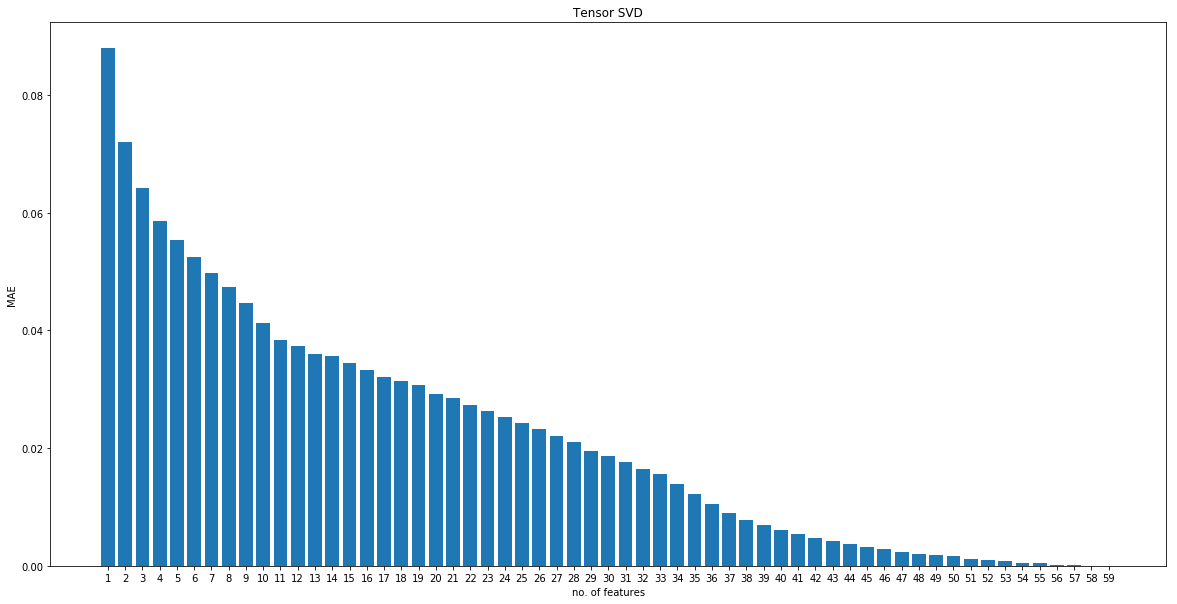

In [60]:
plt.figure(figsize=(20,10))
plt.bar(range(len(y_axis)) , y_axis)
plt.xticks(range(len(y_axis)) ,  x_axis)
plt.xlabel('no. of features')
plt.ylabel('MAE')
plt.title('Tensor SVD')

In [94]:
## pick 20 features from the 
core,factors = partial_tucker(x_norm,modes=[2],rank=[45])

core[0,0,0] , core[1,0,0]

core.shape

(96, 19, 45)

In [95]:
## unrolling the timesteps

In [96]:
def time_step_unroll(M):
    M = np.array([i.ravel() for i in M])
    return M

In [97]:
core_unroll = time_step_unroll(core)

In [98]:
core_unroll[0,0] , core_unroll[1,0]

(-1.4489492156365924, -0.11212521130751646)

In [99]:
core_unroll.max() , core_unroll.min()

(2.0253342343580836, -4.038989299223781)

In [100]:
core.shape

(96, 19, 45)

In [101]:
from sklearn.cluster import KMeans

In [102]:
from sklearn.preprocessing import MinMaxScaler

In [103]:
scaler = MinMaxScaler()
core_unroll = scaler.fit_transform(core_unroll)

In [104]:
core_unroll.max() , core_unroll.min()

(1.0000000000000002, 0.0)

Text(0.5,1,'Tensor-SVD elbow method')

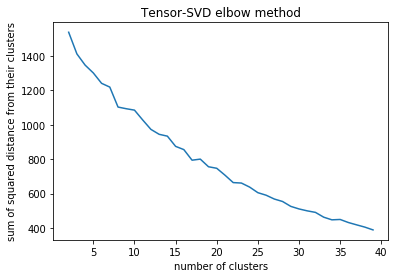

In [126]:
X = core_unroll

from sklearn.cluster import KMeans

inertia_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = (kmeans.inertia_)
    inertia_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,inertia_list)
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distance from their clusters')
# plt.yscale('log')
plt.title('Tensor-SVD elbow method')

1.PCA , other tech.

2.features correlation with target

3.Loop features -> distance metrics

4.Step 19 -> (5,5,5)

5.Other features , GDP , OIL prices , Consumer sent. index. 

In [110]:
from sklearn.metrics import silhouette_score

In [105]:
X = core_unroll

In [107]:
855/19

45.0

In [114]:
def get_f1(n_clus=50):
    l1 = []
    l2 = []
    for _ in range(n_clus):
        kmeans = KMeans(n_clusters=n_clus)
        kmeans.fit(X)
        kmeans.labels_
        l1.append(kmeans.inertia_) ; l2.append(silhouette_score(X,kmeans.labels_))
    print(max(l1)-min(l1) , max(l2)-min(l2))
    return l1,l2

In [74]:
plt.plot(x_axis, sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

NameError: name 'sil_list' is not defined

Text(0.5,1,'Tensor-SVD elbow method')

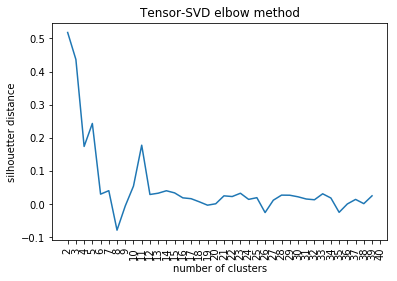

In [122]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = silhouette_score(X  , kmeans.labels_)
    sil_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

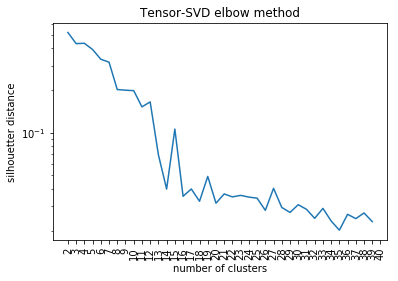

In [253]:
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

In [52]:
for i in range(1,len(inertia_list)):
    print(inertia_list[i]-inertia_list[i-1])

-85.70284536835766
-33.37625781756151
-26.9760593649155
-84.95758550234314
-25.643068983333023
-110.52797510721803
-27.81917729911015
-69.50204218329623
-1.7505382665982552
-36.54027823684328
-43.04286512589624
-17.897308131528803
-37.13699221297111
-58.64207827243854
-29.739284527081963
-12.013177269592802
-40.75130939550684
-26.49547903609789
-22.87948289822498
-37.40820344962026
-30.68265747481371
-7.622575111175138
-23.07511906160562
-1.6275791092481313
-25.469356087420806
-33.658431536173566
-8.629120952712242


In [46]:
X = core_unroll

In [47]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/TensorSVD_10_clusters.csv',index = False)

96


In [266]:
file_name

'./data/15_18/.xlsx'

In [270]:
clus_start = int(input('enter the starting cluster number'))
clus_end = int(input('enter the ending cluster number'))
file_name = str(clus_start)+'_'+str(clus_end)
file_name = os.path.join('./data',file_name+'.xlsx')
writer = pd.ExcelWriter(file_name)
for n_clus in range(clus_start , clus_end+1):
    kmeans = KMeans(n_clusters=n_clus)
    kmeans.fit(X)

    cmpy_names = list(cmpy_dict.keys())
    print(len(cmpy_names))

    ll = zip(list(cmpy_names) , list(kmeans.labels_))

    from collections import defaultdict

    ll_dict = defaultdict(list)

    for i,j in ll:
        ll_dict[j] = ll_dict[j]+[i]

    print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
    print_df.to_excel(writer,str(n_clus)+'clusters')
writer.save()

96
96
96
96
